In [8]:
# lstm 모델

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# TensorFlow/Keras
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. 전처리된 데이터 로드

# 특성 데이터 로드
X_train_scaled = joblib.load('../processed_data/X_train_scaled.pkl')
X_val_scaled = joblib.load('../processed_data/X_val_scaled.pkl')
X_test_scaled = joblib.load('../processed_data/X_test_scaled.pkl')

# 라벨 데이터 로드
y_train = joblib.load('../processed_data/y_train.pkl')
y_val = joblib.load('../processed_data/y_val.pkl')
y_test = joblib.load('../processed_data/y_test.pkl')

# 공통 스케일러 로드
scaler = joblib.load('../models/scaler.pkl')

print(f"데이터 로드 완료:")
print(f"  특성 데이터:")
print(f"    - X_train: {X_train_scaled.shape} (samples, timesteps, features)")
print(f"    - X_val:   {X_val_scaled.shape}")
print(f"    - X_test:  {X_test_scaled.shape}")

print(f"  라벨 데이터:")
print(f"    - y_train: {y_train.shape} (고장 비율: {y_train.sum()/len(y_train)*100:.1f}%)")
print(f"    - y_val:   {y_val.shape} (고장 비율: {y_val.sum()/len(y_val)*100:.1f}%)")
print(f"    - y_test:  {y_test.shape} (고장 비율: {y_test.sum()/len(y_test)*100:.1f}%)")

print(f"  스케일러: 특성 {scaler.n_features_in_}개 정규화 완료")

# 데이터 형태 확인
window_size = X_train_scaled.shape[1]
n_features = X_train_scaled.shape[2]
print(f"\n모델 입력 차원:")
print(f"  - 윈도우 크기: {window_size}")
print(f"  - 특성 개수: {n_features}")


데이터 로드 완료:
  특성 데이터:
    - X_train: (5996, 10, 8) (samples, timesteps, features)
    - X_val:   (1254, 10, 8)
    - X_test:  (1254, 10, 8)
  라벨 데이터:
    - y_train: (5996,) (고장 비율: 15.1%)
    - y_val:   (1254,) (고장 비율: 15.6%)
    - y_test:  (1254,) (고장 비율: 15.6%)
  스케일러: 특성 8개 정규화 완료

모델 입력 차원:
  - 윈도우 크기: 10
  - 특성 개수: 8


In [9]:
# 2. LSTM 모델 구축

# 모델 구조
model = Sequential([
    # LSTM 레이어 1
    LSTM(64, activation='tanh', return_sequences=True, 
         input_shape=(window_size, n_features)),
    Dropout(0.2),
    
    # LSTM 레이어 2
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    
    # Dense 레이어
    Dense(16, activation='relu'),
    Dropout(0.2),
    
    # 출력 레이어 (이진 분류)
    Dense(1, activation='sigmoid')
])

# 모델 컴파일
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall')]
)

# 모델 구조 출력
print(f"모델 구축 완료:")
model.summary()

print(f"\n모델 정보:")
print(f"  - 입력: (None, {window_size}, {n_features})")
print(f"  - 출력: (None, 1) - 고장 확률")
print(f"  - 파라미터: {model.count_params():,}개")

모델 구축 완료:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 10, 64)         │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,649 (123.63 KB)

 Trainable params: 31,649 (123.63 KB)

 Non-trainable params: 0 (0.00 B)


모델 정보:
  - 입력: (None, 10, 8)
  - 출력: (None, 1) - 고장 확률
  - 파라미터: 31,649개


In [10]:
# 3. 모델 학습

# Early Stopping 설정
early_stop = EarlyStopping(
    monitor='val_loss',      # Val loss 모니터링
    patience=10,             # 10 epoch 개선 없으면 중단
    restore_best_weights=True,  # 최고 성능 모델로 복원
    verbose=1
)

# 모델 학습
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# 학습 결과 요약
final_train_loss = history.history['loss'][-1]
final_train_acc = history.history['accuracy'][-1]
final_val_loss = history.history['val_loss'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"\n학습 완료! 최종 성능:")
print(f"  Train: Loss {final_train_loss:.4f}, Acc {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"  Val:   Loss {final_val_loss:.4f}, Acc {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")

# 과적합 체크
gap_train_val = final_train_acc - final_val_acc
print(f"\n과적합 체크:")
print(f"  Train-Val 차이: {gap_train_val:.4f} ({gap_train_val*100:.2f}%p)")

if gap_train_val > 0.1:
    print("  과적합 가능성 높음 (차이 > 10%)")
elif gap_train_val > 0.05:
    print("  약간 과적합 (차이 5~10%)")
else:
    print("  과적합 없음 (차이 < 5%)")

Epoch 1/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9475 - loss: 0.1525 - precision: 0.8568 - recall: 0.7841 - val_accuracy: 0.9545 - val_loss: 0.1802 - val_precision: 0.9792 - val_recall: 0.7231
Epoch 2/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9626 - loss: 0.0799 - precision: 0.8826 - recall: 0.8689 - val_accuracy: 0.9490 - val_loss: 0.0896 - val_precision: 0.8104 - val_recall: 0.8769
Epoch 3/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9716 - loss: 0.0651 - precision: 0.9203 - recall: 0.8899 - val_accuracy: 0.9537 - val_loss: 0.0889 - val_precision: 0.9597 - val_recall: 0.7333
Epoch 4/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9780 - loss: 0.0594 - precision: 0.9470 - recall: 0.9053 - val_accuracy: 0.9442 - val_loss: 0.0808 - val_precision: 0.8453 - val_recall: 0.7846
Epoch 5/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9798 - loss: 0.0512 - precision: 0.9518 - recall: 0.9130 - val_accuracy: 0.9577 - val_los

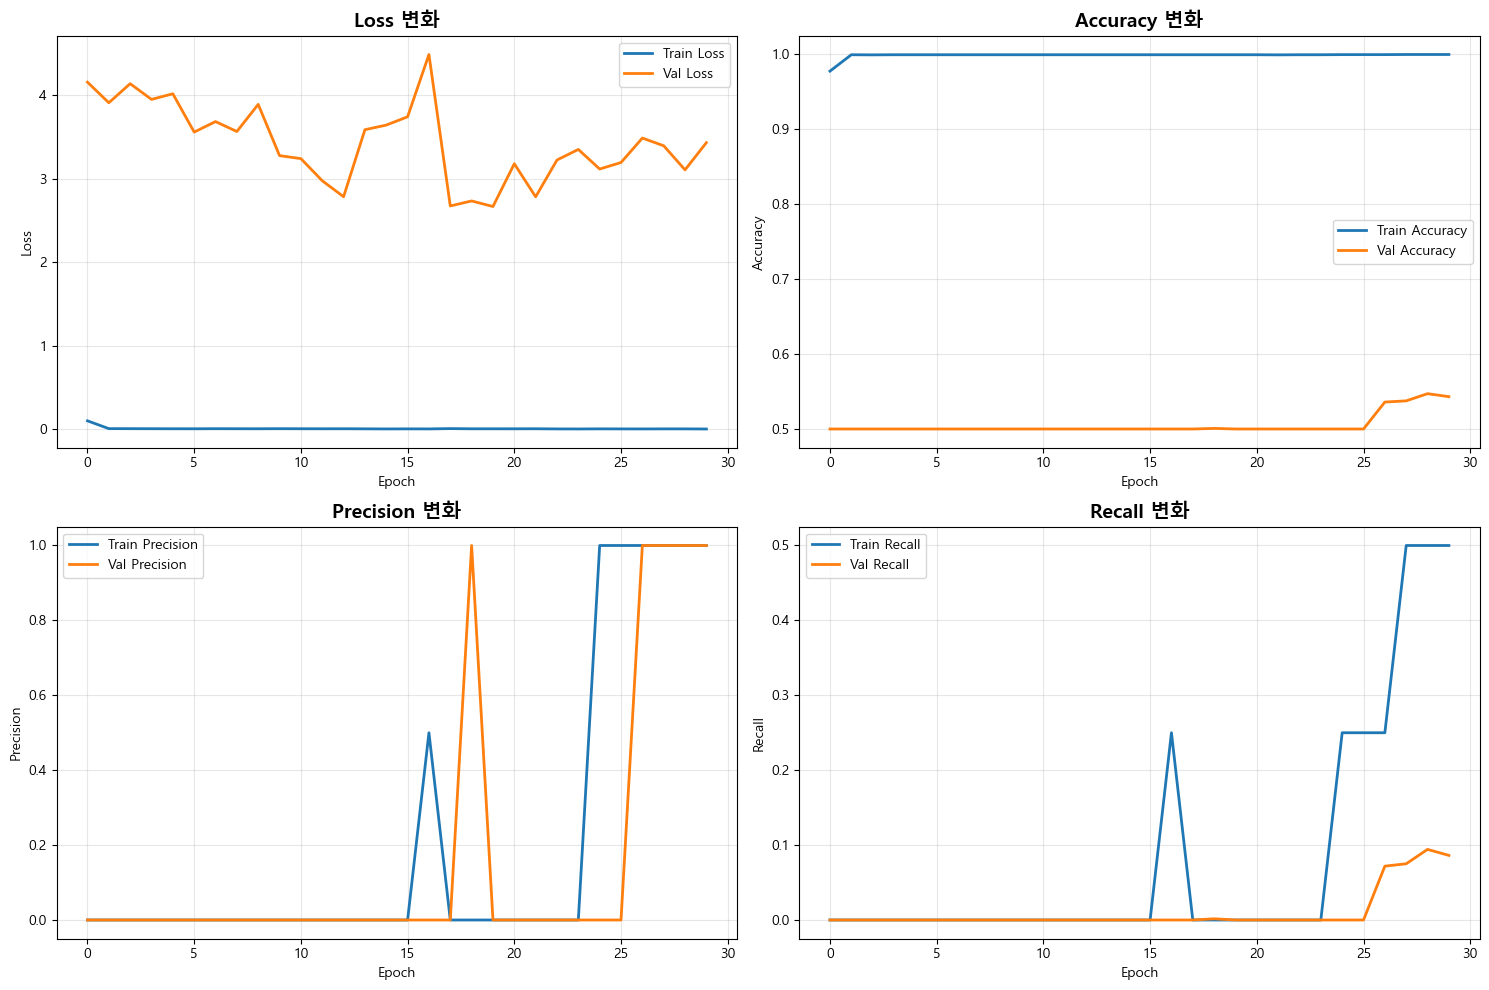

In [5]:
# 4. 학습 곡선 시각화

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
ax = axes[0, 0]
ax.plot(history.history['loss'], label='Train Loss', linewidth=2)
ax.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
ax.set_title('Loss 변화', fontsize=14, fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True, alpha=0.3)

# Accuracy
ax = axes[0, 1]
ax.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
ax.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
ax.set_title('Accuracy 변화', fontsize=14, fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
ax.grid(True, alpha=0.3)

# Precision
ax = axes[1, 0]
ax.plot(history.history['precision'], label='Train Precision', linewidth=2)
ax.plot(history.history['val_precision'], label='Val Precision', linewidth=2)
ax.set_title('Precision 변화', fontsize=14, fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Precision')
ax.legend()
ax.grid(True, alpha=0.3)

# Recall
ax = axes[1, 1]
ax.plot(history.history['recall'], label='Train Recall', linewidth=2)
ax.plot(history.history['val_recall'], label='Val Recall', linewidth=2)
ax.set_title('Recall 변화', fontsize=14, fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Recall')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
# 5. Test 성능 평가

# 예측
y_pred_prob = model.predict(X_test_scaled, verbose=0)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# 성능 지표 계산
test_acc = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)

print(f"\nTest 성능:")
print(f"  Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"  Precision: {test_precision:.4f} ({test_precision*100:.2f}%)")
print(f"  Recall:    {test_recall:.4f} ({test_recall*100:.2f}%)")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:")
print(cm)
print(f"  TN (정상→정상):  {cm[0,0]}")
print(f"  FP (정상→고장):  {cm[0,1]} (거짓 경보)")
print(f"  FN (고장→정상):  {cm[1,0]} (고장 놓침)")
print(f"  TP (고장→고장):  {cm[1,1]}")

# 분류 리포트
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['정상 (0)', '고장 (1)']))


Test 성능:
  Accuracy:  0.9689 (96.89%)
  Precision: 0.8861 (88.61%)
  Recall:    0.9179 (91.79%)

Confusion Matrix:
[[1036   23]
 [  16  179]]
  TN (정상→정상):  1036
  FP (정상→고장):  23 (거짓 경보)
  FN (고장→정상):  16 (고장 놓침)
  TP (고장→고장):  179

Classification Report:
              precision    recall  f1-score   support

      정상 (0)       0.98      0.98      0.98      1059
      고장 (1)       0.89      0.92      0.90       195

    accuracy                           0.97      1254
   macro avg       0.94      0.95      0.94      1254
weighted avg       0.97      0.97      0.97      1254



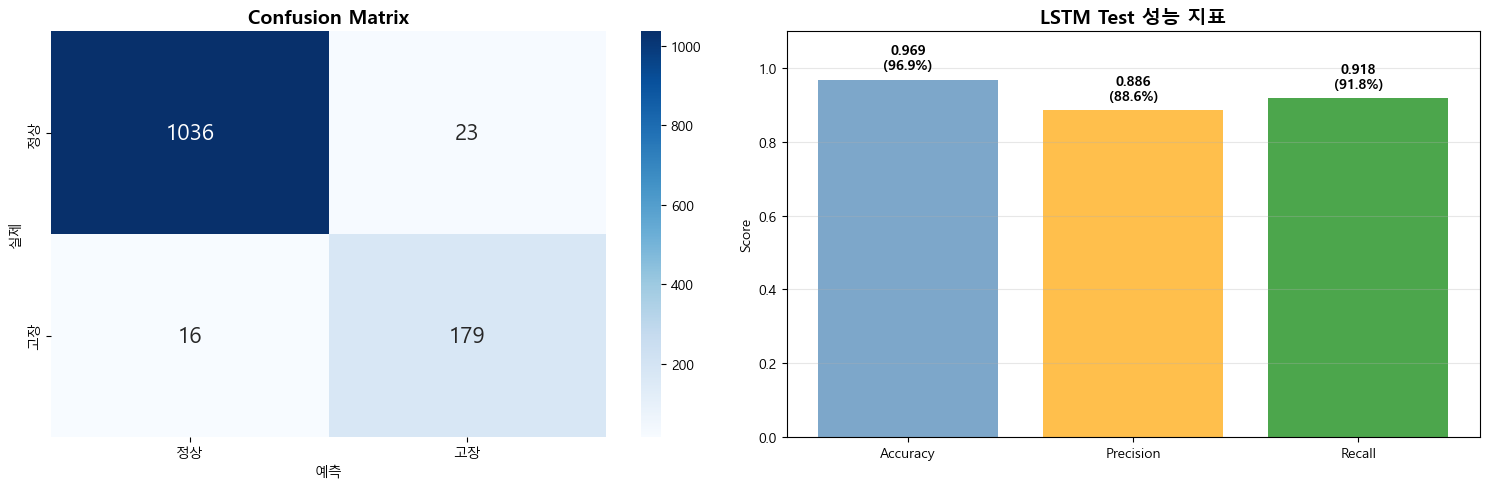

In [12]:
# 6. 결과 시각화

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Confusion Matrix 히트맵
ax = axes[0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['정상', '고장'],
            yticklabels=['정상', '고장'],
            ax=ax, cbar=True, annot_kws={'size': 16})
ax.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
ax.set_xlabel('예측')
ax.set_ylabel('실제')

# 성능 지표 비교
ax = axes[1]
metrics = ['Accuracy', 'Precision', 'Recall']
values = [test_acc, test_precision, test_recall]
colors = ['steelblue', 'orange', 'green']

bars = ax.bar(metrics, values, color=colors, alpha=0.7)
ax.set_ylim(0, 1.1)
ax.set_title('LSTM Test 성능 지표', fontsize=14, fontweight='bold')
ax.set_ylabel('Score')
ax.grid(True, alpha=0.3, axis='y')

# 값 표시
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{value:.3f}\n({value*100:.1f}%)',
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [13]:
# 7. 모델 및 결과 저장

# 저장 경로
models_dir = '../models'
os.makedirs(models_dir, exist_ok=True)

# LSTM 모델 저장
model_save_path = f'{models_dir}/model_lstm.keras'
model.save(model_save_path)
print(f"LSTM 모델 저장: {model_save_path}")

# 결과 딕셔너리 생성
results_lstm = {
    'model_name': 'LSTM',
    'model_type': 'deep_learning',
    'model_file': 'model_lstm.keras',  # 모델 파일 경로
    'accuracy': test_acc,
    'precision': test_precision,
    'recall': test_recall,
    'confusion_matrix': cm.tolist(),  # numpy → list 변환
    'y_true': y_test.tolist(),
    'y_pred': y_pred.tolist(),
    'y_pred_prob': y_pred_prob.flatten().tolist(),
    'training_history': history.history,  # 학습 곡선 데이터
    'model_params': model.count_params(),
    'input_shape': (window_size, n_features),
    'epochs_trained': len(history.history['loss'])
}

# 결과 저장
results_save_path = f'{models_dir}/results_lstm.pkl'
joblib.dump(results_lstm, results_save_path)
print(f"LSTM 결과 저장: {results_save_path}")

print(f"\n저장된 파일들:")
print(f"  - model_lstm.keras: 모델 가중치 및 구조")
print(f"  - results_lstm.pkl: 성능 지표 및 메타데이터")
print(f"  - scaler.pkl: 정규화 스케일러")

LSTM 모델 저장: ../models/model_lstm.keras
LSTM 결과 저장: ../models/results_lstm.pkl

저장된 파일들:
  - model_lstm.keras: 모델 가중치 및 구조
  - results_lstm.pkl: 성능 지표 및 메타데이터
  - scaler.pkl: 정규화 스케일러


# LSTM 모델 결과 요약

## 성능
- **Test Accuracy**: 96.89%
- **Test Precision**: 88.61%
- **Test Recall**: 91.79%
- **Test F1-score**: 90.18%

## 주요 발견
- 고장 195개 중 179개 성공적으로 감지 (16개 놓침)
- 시계열 패턴 학습으로 높은 예측 정확도 달성
- 계층적 분할로 안정적 성능 확보

## 다음 단계
- 해당 모델을 베이스라인으로 설정
- GRU, CNN 등 다른 딥러닝 모델과 비교
- 목표: Precision > 90% 유지하면서 Recall 향상